In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


**This is for distorted image. The average color inside the contour is checked to see if it is a white square or black square
**

In [ ]:
original_image = cv2.imread('/content/drive/MyDrive/distorted_image.png')

rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

In [ ]:
copy=original_image.copy()

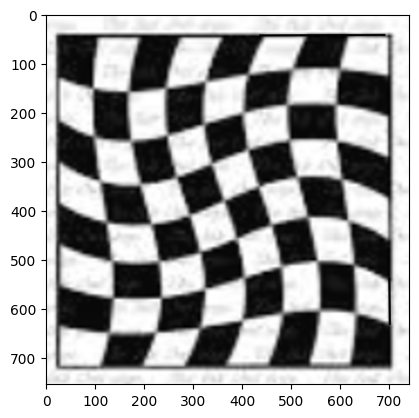

In [ ]:
plt.imshow(original_image)

In [ ]:
gaussian_blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
ret,otsu_binary = cv2.threshold(gaussian_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [ ]:
otsu_binary_copy=otsu_binary.copy()

In [ ]:
canny = cv2.Canny(otsu_binary,20,255)

kernel = np.ones((9, 9), np.uint8)

img_dilation = cv2.dilate(canny, kernel, iterations=1)

For distorted image ,Hough transform is not applied. Here I am trying to detect black and white squares in two methods. One method is finding the contours and since the contours are not rect in shape cannot be approximated to rectangles. So avg color enclosed by the contour is calculated and classified as black and white.

In [ ]:
board_contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

array([[[254, 254, 254],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 252, 252],
        [251, 251, 251],
        [251, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 252, 252],
        [252, 252, 252],
        [251, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [252, 252, 252],
        [251, 251, 251],
        [251, 251, 251]],

       ...,

       [[242, 242, 242],
        [240, 240, 240],
        [238, 238, 238],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [242, 242, 242]],

       [[246, 246, 246],
        [245, 245, 245],
        [244, 244, 244],
        ...,
        [248, 248, 248],
        [247, 247, 247],
        [247, 247, 247]],

       [[248, 248, 248],
        [247, 247, 247],
        [246, 246, 246],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]]], dtype=uint8)
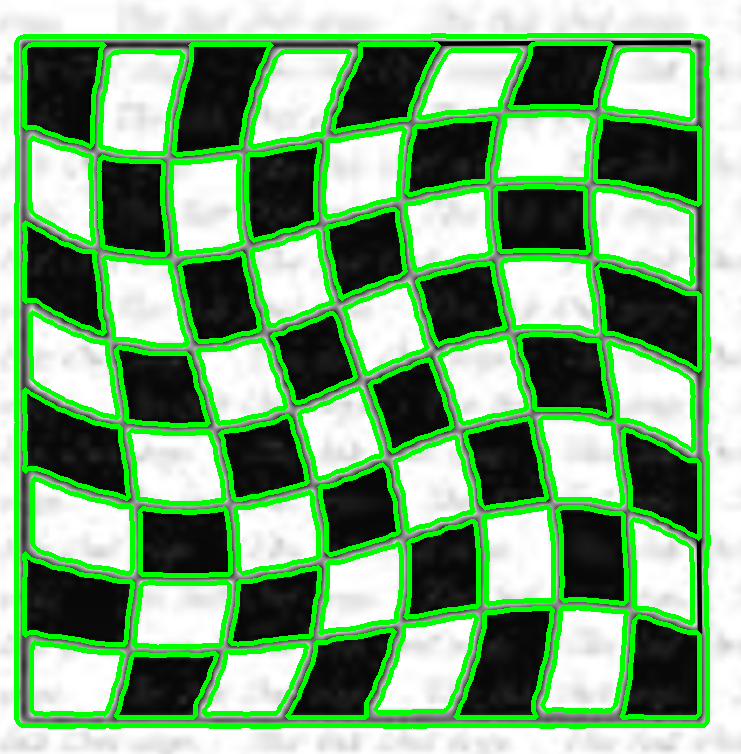

In [ ]:
cv2.drawContours(original_image,board_contours,-1,(0,255,0),3)

In [ ]:
len(board_contours)

65

In [ ]:


# Initialize counters
white_count = 0
black_count = 0

# Loop over contours
for i, cnt in enumerate(board_contours):
    area = cv2.contourArea(cnt)
    if 200 < area < 8000:
        # Create a single-channel mask
        mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

        # Draw the filled contour on the mask
        cv2.drawContours(mask, [cnt], -1, 255, thickness=-1)

        # Extract pixel values inside the contour from the original image
        contour_pixels = original_image[mask == 255]

        # Compute average intensity
        avg_color = np.mean(contour_pixels)

        # Classification logic
        if avg_color > 100:  # You can adjust this threshold
            white_count += 1
        else:
            black_count += 1

# Print result
print(f"white_count: {white_count}, black_count: {black_count}")


white_count: 32, black_count: 32


The second method is convex hull contour approximation. The value of epsilon is increased to approximate the ccordinates to qaudrilateral and then hull is drawn and the avg color inside the hull is calculated and according classified as black and white.

In [ ]:
white_count = 0
black_count = 0
avg_colors = []
# Loop over contours
for i, cnt in enumerate(board_contours):
    area = cv2.contourArea(cnt)
    if 200 < area < 8000:

        # Draw the filled contour on the mask
        epsilon = 0.045 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        hull = cv2.convexHull(approx, returnPoints=True)

        # Extract pixel values inside the contour from the original image
        cv2.polylines(otsu_binary_copy, [hull], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(copy, [hull], isClosed=True, color=(0, 255, 0), thickness=2)
        # Create a mask for  hull
        mask = np.zeros(otsu_binary.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [hull], 255)
        # Get pixel values inside the mask
        contour_pixels = otsu_binary[mask == 255]

        avg_color = np.mean(contour_pixels)
        avg_colors.append(avg_color)

# Determine threshold from average of all avg_color values
if avg_colors:
    threshold = np.mean(avg_colors)
    print(f"detected threshold: {threshold:.2f}")

    for avg_color in avg_colors:
        if avg_color > threshold:
            white_count += 1
        else:
            black_count += 1

# Final results
print(f"white_count: {white_count}, black_count: {black_count}")


detected threshold: 127.55
white_count: 32, black_count: 32


Below are images of otsu_binary (thresholded image) and copy of original image with hull drawn on them.

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
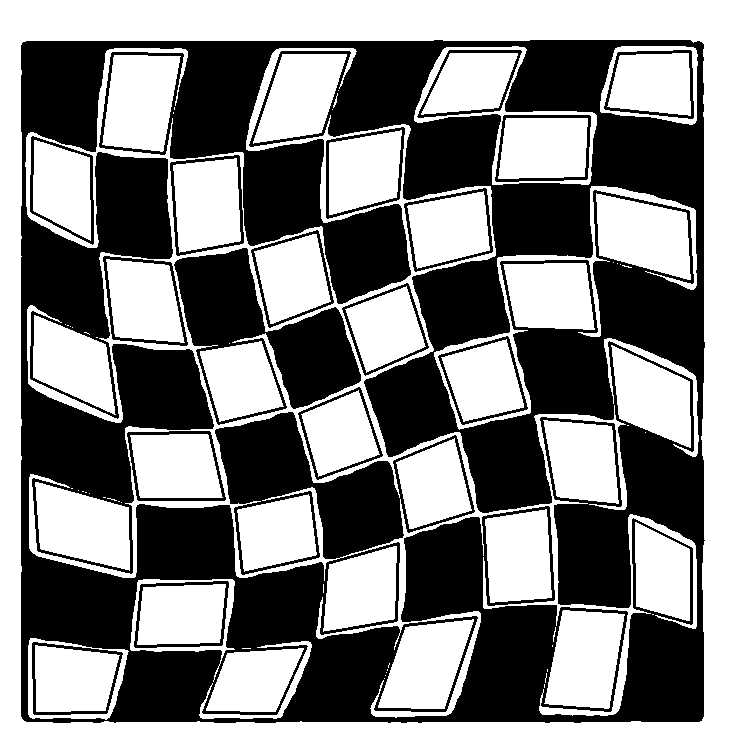

In [ ]:
otsu_binary_copy


array([[[254, 254, 254],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 252, 252],
        [251, 251, 251],
        [251, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 252, 252],
        [252, 252, 252],
        [251, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [252, 252, 252],
        [251, 251, 251],
        [251, 251, 251]],

       ...,

       [[242, 242, 242],
        [240, 240, 240],
        [238, 238, 238],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [242, 242, 242]],

       [[246, 246, 246],
        [245, 245, 245],
        [244, 244, 244],
        ...,
        [248, 248, 248],
        [247, 247, 247],
        [247, 247, 247]],

       [[248, 248, 248],
        [247, 247, 247],
        [246, 246, 246],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]]], dtype=uint8)
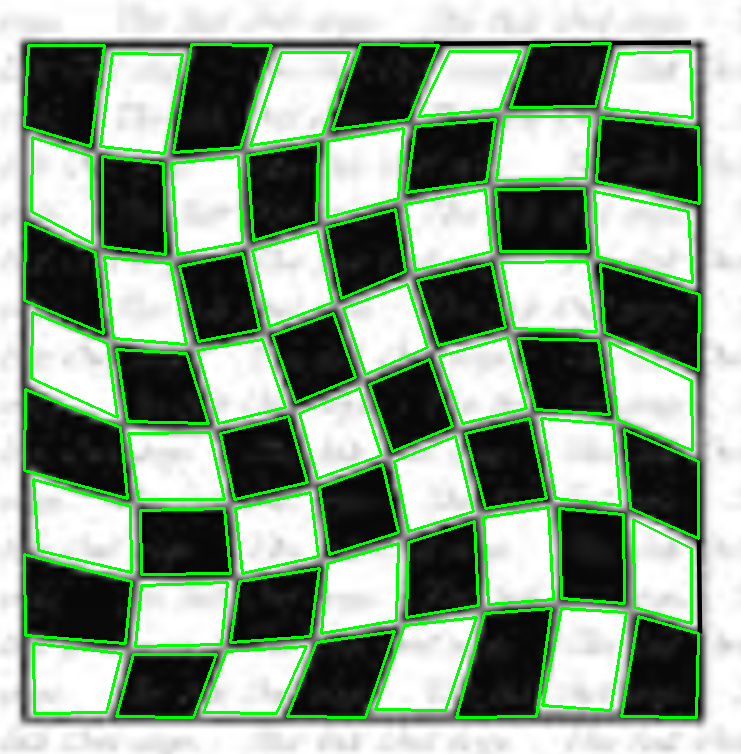

In [ ]:
copy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
original_image = cv2.imread('.data/chessboard5.png')

rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

In [135]:
copy=original_image.copy()

This image has thick edges and white patches, so the algorithm when detecting contours is taking this into account and the required contour around each white square is not obtained as expected. Convex hull approximation is

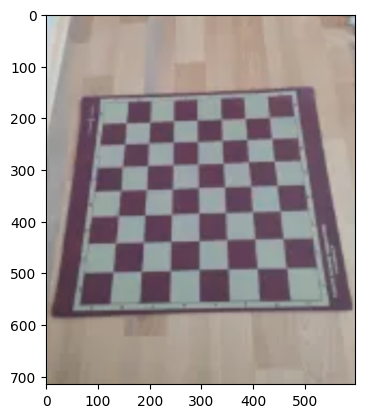

In [136]:
plt.imshow(original_image)

In [137]:
gaussian_blur = cv2.GaussianBlur(gray_image, (9, 9), 0)
ret,otsu_binary = cv2.threshold(gaussian_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [138]:
otsu_binary_copy=otsu_binary.copy()

In [139]:
canny = cv2.Canny(otsu_binary,100,255)

kernel = np.ones((9, 9), np.uint8)

img_dilation = cv2.dilate(canny, kernel, iterations=1)

In [140]:
board_contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

array([[[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [139, 152, 166],
        [139, 153, 167],
        [166, 178, 189]],

       [[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [143, 156, 170],
        [143, 156, 170],
        [168, 180, 191]],

       [[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [148, 161, 175],
        [147, 160, 174],
        [171, 183, 194]],

       ...,

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [178, 170, 161],
        [178, 172, 164],
        [197, 193, 187]],

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [176, 169, 160],
        [176, 171, 163],
        [196, 192, 185]],

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [175, 169, 160],
        [175, 170, 162],
        [195, 192, 185]]], dtype=uint8)
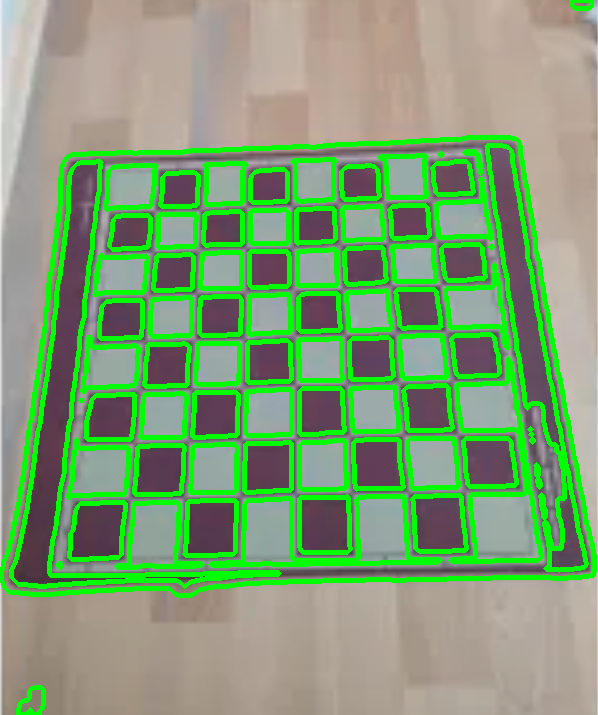

In [141]:
cv2.drawContours(original_image,board_contours,-1,(0,255,0),3)

In [142]:
len(board_contours)

89

In [99]:
white_count = 0
black_count = 0
avg_colors = []
# Loop over contours
for i, cnt in enumerate(board_contours):
    area = cv2.contourArea(cnt)
    if 1000 < area < 9000:

        # Draw the filled contour on the mask
        epsilon = 0.05 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        hull = cv2.convexHull(approx, returnPoints=True)

        # Extract pixel values inside the contour from the original image
        cv2.polylines(otsu_binary_copy, [hull], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(copy, [hull], isClosed=True, color=(0, 255, 0), thickness=2)
        # Create a mask for  hull
        mask = np.zeros(otsu_binary.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [hull], 255)
        # Get pixel values inside the mask
        contour_pixels = otsu_binary[mask == 255]

        avg_color = np.mean(contour_pixels)
        avg_colors.append(avg_color)

# Determine threshold from average of all avg_color values
if avg_colors:
    threshold = np.mean(avg_colors)
    print(f"detected threshold: {threshold:.2f}")

    for avg_color in avg_colors:
        if avg_color > threshold:
            white_count += 1
        else:
            black_count += 1

# Final results
print(f"white_count: {white_count}, black_count: {black_count}")

detected threshold: 118.76
white_count: 30, black_count: 32


THe below images shows the correctly detected squares. For this image since there are white patches the white squares are not detected correctly.

array([[[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [139, 152, 166],
        [139, 153, 167],
        [166, 178, 189]],

       [[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [143, 156, 170],
        [143, 156, 170],
        [168, 180, 191]],

       [[231, 239, 245],
        [217, 230, 239],
        [204, 220, 233],
        ...,
        [148, 161, 175],
        [147, 160, 174],
        [171, 183, 194]],

       ...,

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [178, 170, 161],
        [178, 172, 164],
        [197, 193, 187]],

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [176, 169, 160],
        [176, 171, 163],
        [196, 192, 185]],

       [[210, 208, 199],
        [182, 178, 167],
        [154, 148, 135],
        ...,
        [175, 169, 160],
        [175, 170, 162],
        [195, 192, 185]]], dtype=uint8)
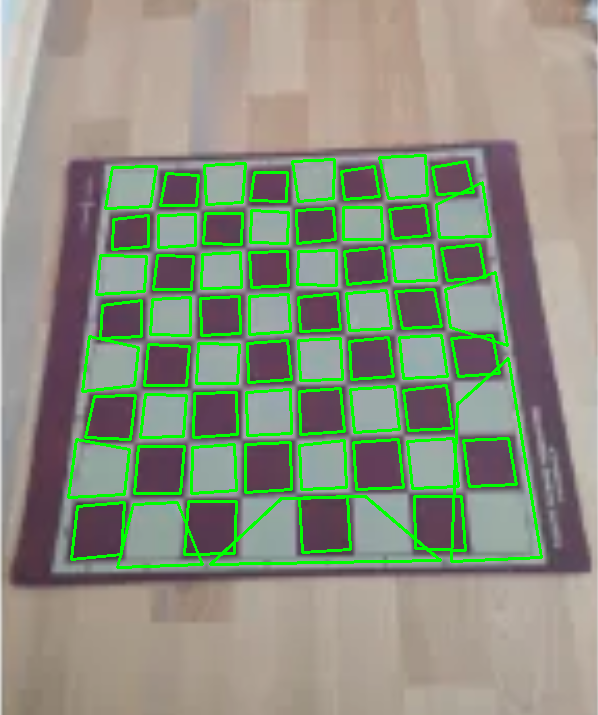

In [100]:
copy

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
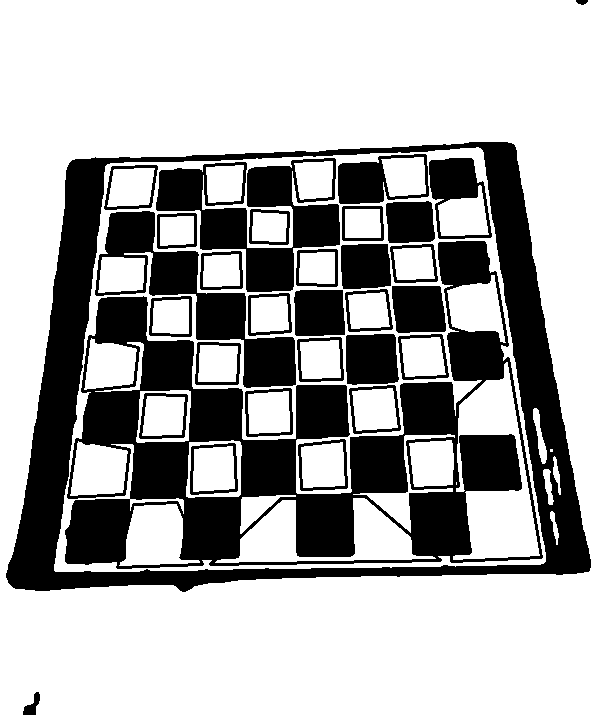

In [101]:
otsu_binary_copy